<a href="https://colab.research.google.com/github/yamenetoo/Artificial-Neural-Network-Analysis-Using-Statistical-Approaches/blob/main/Git_IDCModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepaer data


In [ ]:
import os
import shutil
import subprocess

file_path = "/content/drive/MyDrive/kaggle.json"
kaggle_dir = os.path.expanduser("~/.kaggle")

os.makedirs(kaggle_dir, exist_ok=True)
shutil.copy(file_path, os.path.join(kaggle_dir, "kaggle.json"))

subprocess.run(["ls", "-lha", os.path.join(kaggle_dir, "kaggle.json")])
subprocess.run(["pip", "install", "-q", "kaggle"])
subprocess.run(["kaggle", "datasets", "download", "-d", "paultimothymooney/breast-histopathology-images"])

os.makedirs("/content/data", exist_ok=True)
subprocess.run(["unzip", "/content/breast-histopathology-images.zip", "-d", "/content/data"])

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
import pandas as pd

breast_img = glob.glob('/content/data/IDC_regular_ps50_idx5/**/*.png', recursive=True)
df = pd.DataFrame(breast_img, columns=['image_path'])
df.to_csv("/content/datapath.csv", index=False)

N_IDC = [img for img in breast_img if img[-5] == '0']
P_IDC = [img for img in breast_img if img[-5] == '1']

X, Y = [], []

for img in N_IDC:
    print("N_IDC", img)
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    X.append(n_img_size)
    Y.append(0)

for img in P_IDC:
    print("P_IDC", img)
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    X.append(c_img_size)
    Y.append(1)


In [ ]:
import numpy as np
import pickle

X = np.array(X)
y = np.array(Y)

unique_labels, counts = np.unique(y, return_counts=True)
print(f'Total number of images: {len(X)}')
print(f'Number of IDC(-) Images: {counts[np.where(unique_labels == 0)][0]}')
print(f'Number of IDC(+) Images: {counts[np.where(unique_labels == 1)][0]}')
print(f'Image shape (Width, Height, Channels): {X[0].shape}')

data = {'X': X, 'Y': y}
with open('/content/drive/MyDrive/XY.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


#models

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def val(Y_test, pre):
    target_names = ['negative', 'positive']
    report = classification_report(Y_test.argmax(1), pre, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(report)

    confusion = confusion_matrix(Y_test.argmax(1), pre)

    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt=".0f", xticklabels=target_names, yticklabels=target_names)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()



# pre=model.predict(X_test)
# pre=pre.argmax(1)
# len(pre)

##import data

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pickle
from gc import collect

tf.keras.backend.clear_session()

# Load data (deserialize)
with open('/content/drive/MyDrive/XY.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

X = unserialized_data["X"]
y = unserialized_data["Y"]
print(np.unique(y, return_counts=True))

del unserialized_data
collect()

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=10)
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)


##Deep CNN

In [ ]:

def create_model(input_shape=(50, 50, 3), learning_rate=0.0001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Flatten(name='flatt'))

    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', name='fc1'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', name='fc2'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', name='fc3'))
    model.add(Dropout(0.3))

    model.add(Dense(24, activation='relu', kernel_initializer='he_uniform', name='fc'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model()
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 40)
os.mkdir('/content/drive/MyDrive/DCI/models')
model.save('/content/drive/MyDrive/DCI/models/myModel', overwrite=True, save_format=None)

###load model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/DCI/models/myModel')

###CNN Evaluate

In [ ]:
test_res=model.evaluate(X_test, Y_test,verbose=0)
print("here we can see that the loss of this model is {} , and the accuracy is {} ".format(test_res[0],test_res[1]))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

pre=model.predict(X_test)
pre=pre.argmax(1)
len(pre)

1735/1735 [==============================] - 248s 143ms/step


55505

In [ ]:
"del unserialized_data"
del(X)
from gc import collect
collect ()

1604

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
target_names = ['negative', 'positive']
report=classification_report(Y_test.argmax(1),pre, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
print(classification_report(Y_test.argmax(1),pre,target_names=target_names))


              precision    recall  f1-score   support

    negative       0.94      0.90      0.92     39719
    positive       0.77      0.84      0.81     15786

    accuracy                           0.89     55505
   macro avg       0.85      0.87      0.86     55505
weighted avg       0.89      0.89      0.89     55505



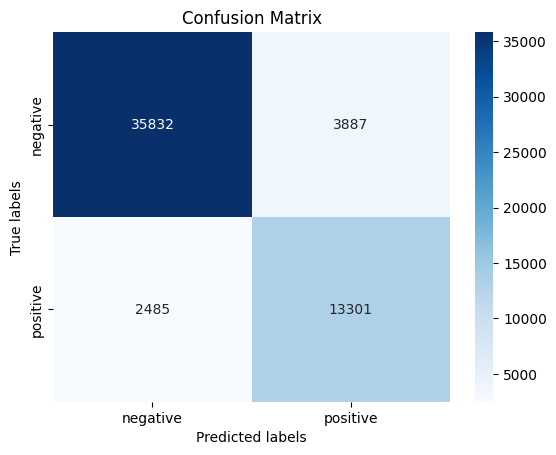

In [ ]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test.argmax(1),pre), annot=True, cmap='Blues',fmt=".0f")

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

#LR model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/DCI/models/myModel')

In [ ]:
# Load data (deserialize)
import pickle
with open('/content/drive/MyDrive/DCI/XY.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

In [ ]:
X=unserialized_data["X"]
y=unserialized_data["Y"]
np.unique(y,return_counts=True)

(array([0, 1]), array([198738,  78786]))

In [ ]:
del(unserialized_data)
from gc import collect
collect()

0

In [ ]:
from keras.models import Model
layer_name = 'fc'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X,verbose=0)
new_X=intermediate_output

In [ ]:
print("the new shape of data is {}".format(new_X.shape))

the new shape of data is (277524, 24)


Text(0.5, 0, 'neurons')

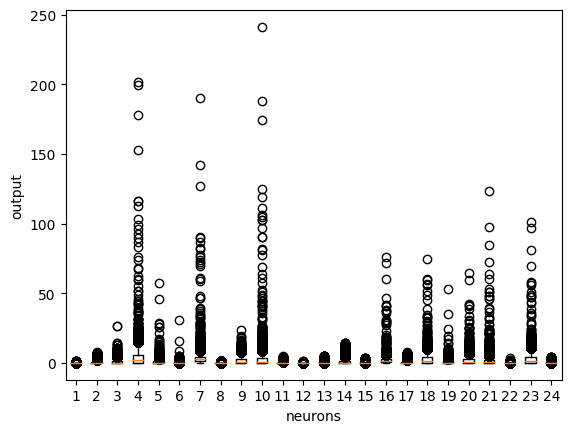

In [ ]:
_=plt.boxplot(new_X)
plt.ylabel('output')
plt.xlabel('neurons')

## convert output to csv file

In [ ]:
df=pd.DataFrame(new_X)
df.colnms=["X_{}".format(i) for i in range(1,25)]
df["y"]=y
df=df[pd.notnull(df)]

df.to_csv("res_of_cnn_output.csv")

#pca model

In [ ]:
from keras.metrics.accuracy_metrics import accuracy
def get_pca(n_components,X):
  pca = PCA(n_components)
  pca.fit(new_X)
  print("the explanined variance of {} components is {}".format(n_components,pca.explained_variance_ratio_.sum()))
  pca_X=pca.transform(new_X)
  return([pca_X,pca.explained_variance_ratio_.sum()])

def pca_LR(n_components,X):
  pca_X,exp_var=get_pca(n_components,X)
  X_train, X_test, Y_train, Y_test = train_test_split(pca_X, y, test_size=0.2,random_state=10)
  clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
  pre=clf.predict(X_test)
  accuracy=clf.score(X_test,Y_test)
  print("the accuracy of LR model with {} components is {},".format(n_components,accuracy ))
  return([accuracy,exp_var])



In [ ]:
acc_dic={  "n_components":[],
           "accuracy":[],
           "explanined_variance":[]
         }
for n_components in range(1,24):

  print("nunber of components=",n_components)
  acc_dic["n_components"].append(n_components)
  res=pca_LR(n_components,new_X)
  acc_dic["accuracy"].append(res[0])
  acc_dic["explanined_variance"].append(res[1])
  print("*"*75)

In [ ]:
pca_X,_=get_pca(6,new_X)
pca_X.shape

the explanined variance of 6 components is 0.9659927088504207


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(pca_X, y, test_size=0.2,random_state=10)
del(X);collect()

1069

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(Y_train),y = Y_train)
class_weights = dict(zip(np.unique(Y_train), class_weights)),
class_weights

({0: 0.6980895364704847, 1: 1.7620555555555555},)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
pre=clf.predict(X_test)
accuracy=clf.score(X_test,Y_test)
accuracy

0.8886046302134942

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
target_names = ['negative', 'positive']
report=classification_report(Y_test,pre, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
print(classification_report(Y_test,pre, target_names=target_names))
df.to_csv("LRmodel.csv")

              precision    recall  f1-score   support

    negative       0.92      0.92      0.92     39719
    positive       0.80      0.81      0.81     15786

    accuracy                           0.89     55505
   macro avg       0.86      0.87      0.86     55505
weighted avg       0.89      0.89      0.89     55505



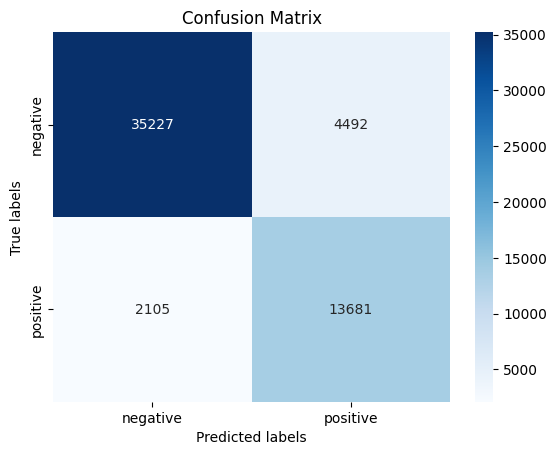

In [ ]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test,pre), annot=True, cmap='Blues',fmt=".0f")

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);
plt.show()

#LR model

In [ ]:
!pip install statsmodels
!pip install scikit_posthocs
import scikit_posthocs as sp

In [ ]:
X_t=pd.DataFrame(X_test)
X_t.columns=["β{}".format(i) for i in range(1,X_train.shape[1]+1)]

In [ ]:
# importing statsmodels
import statsmodels.api as sm
# building the model and fitting the data
X_=pd.DataFrame(X_train)
X_.columns=["β{}".format(i) for i in range(1,X_train.shape[1]+1)]
Y_=pd.DataFrame(Y_train)
X_=sm.add_constant(X_)
log_reg = sm.Logit( Y_,X_).fit()
print(log_reg.summary())

In [ ]:
LLfull_model=log_reg.llf;LLfull_model

In [ ]:
pd.DataFrame(log_reg.summary().tables[0])

In [ ]:
res=pd.DataFrame(log_reg.summary().tables[1])
#print(res)
col=res.iloc[0,:]
index=res.iloc[:,0]

In [ ]:
res

# new scouers of data

In [ ]:
!wget   http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip

--2023-05-28 06:41:46--  http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip
Resolving andrewjanowczyk.com (andrewjanowczyk.com)... 129.22.136.73
Connecting to andrewjanowczyk.com (andrewjanowczyk.com)|129.22.136.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1644892042 (1.5G) [application/zip]
Saving to: ‘IDC_regular_ps50_idx5.zip’

IDC_regular_ps50_id 100%[===================>]   1.53G  7.62MB/s    in 5m 11s  

2023-05-28 06:46:57 (5.04 MB/s) - ‘IDC_regular_ps50_idx5.zip’ saved [1644892042/1644892042]



In [ ]:
!unzip /content/IDC_regular_ps50_idx5.zip -d /content/data

In [ ]:
import glob
breast_img = glob.glob('/content/data/**/*.png', recursive = True) # استدعاء الصور من الدرايف
import pandas as pd
df=pd.DataFrame(breast_img)
df.to_csv("/content/datapath.csv")


In [ ]:
# استدعاء المكاتب
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np # مكتبة جبر
import pandas as pd # مكتبة جداول
import matplotlib.pyplot as plt # مكتبة رسم
%matplotlib inline
import seaborn as sns # مكتبة رسم وتنسيق جداول
import cv2 # مكتبة معالجة الصور
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential # مكتبة الشبكات العصبية
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization # مكتبة الشبكات العصبية
from tensorflow.keras.optimizers import SGD # مكتبة الشبكات العصبية
import pandas as pd

In [ ]:
N_IDC = []   # N_IDC negative IDC غير مصاب
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)

    elif img[-5] == '1' :
        P_IDC.append(img)

In [ ]:
print("N_IDC",len(N_IDC))
print("P_IDC",len(P_IDC))


In [ ]:
import shutil
os.mkdir("/content/2class data/N")
for i in N_IDC:
  name=i.split("/")[-1]
  shutil.copyfile(i, "/content/2class data/N/"+name)

In [ ]:
import shutil
os.mkdir("/content/2class data/P")
for i in P_IDC:
  name=i.split("/")[-1]
  shutil.copyfile(i, "/content/2class data/P/"+name)

##data Augmantiation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
def dataGenerator(type_="P", number=2):

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    )

    for filename in os.listdir(f'/content/2class data/{type_}/'):
        if filename.endswith('png'):
            img = load_img(f'/content/2class data/{type_}/{filename}')
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=f'/content/generate_data/', save_prefix='IMG', save_format='png'):
                i += 1
                if i == number:
                    break

dataGenerator()

In [ ]:
def dataGenerator(type_="P", number=2):

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    )

    for i in X_train[index]:
      x = x.reshape((1,) + x.shape)
      i = 0
      for batch in datagen.flow(x, batch_size=1, save_to_dir=f'/content/generate_data/', save_prefix='IMG', save_format='png'):
        i += 1
        if i == number:
          break

In [ ]:
non_img_arr = []
can_img_arr = []
for img in N_IDC:
    print("N_IDC",img)
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
for img in P_IDC:
    print("P_IDC",img)
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [ ]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
import pickle
data = {'X': X,"Y":y}

with open('/content/drive/MyDrive/DCI/new_XY.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,random_state=10)

In [ ]:
index=np.where(Y_train==1)[0]
index

array([    17,     24,     54, ..., 221944, 221994, 222018])

In [ ]:
datagen = ImageDataGenerator(
  rotation_range=40,
  #width_shift_range=0.2,
  #height_shift_range=0.2,
  shear_range=0.2,
  #zoom_range=0.2,
  fill_mode='nearest',
  horizontal_flip=True,
)
for i in X_train[index]:
  img= i.reshape((1,) + i.shape)
  aug_iter = datagen.flow(img, batch_size=1)
  for i in range(1):
    image = next(aug_iter)[0].astype('uint8')
    X_train=np.append(image.reshape(1,50,50,3),X_train,axis=0)
    Y_train=np.append(1,Y_train)

In [ ]:
np.unique(Y_train,return_counts=True)

(array([0, 1]), array([211927,  14303]))

In [ ]:
import pickle
data = {"X_train":X_train, "X_test":X_test, "Y_train":Y_train, "Y_test":Y_test}



In [ ]:
with open('/content/drive/MyDrive/DCI/AUG_train_test_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load data (deserialize)
import pickle
with open('/content/drive/MyDrive/DCI/AUG_train_test_data.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,random_state=10)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3),activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten(name='flatt'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform',name='fc1'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform',name='fc2'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform',name='fc3'))
model.add(Dropout(0.3))
###################################################################################
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform',name='fc'))#
###################################################################################
model.add(Dense(2, activation='softmax'))
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 10)

6939/6939 [==============================] - 121s 17ms/step - loss: 0.0698 - accuracy: 0.9743 - val_loss: 0.1042 - val_accuracy: 0.9643


#red_model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3),activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten(name='flatt'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform',name='fc1'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform',name='fc2'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform',name='fc3'))
model.add(Dropout(0.3))
###################################################################################
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform',name='fc'))#
###################################################################################
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
input_shape=(50, 50, 3)
def make_index_weights(indexes):
    # converting indexes to a list of weights
    indexes = [ float(i not in indexes) for i in range(units) ]
    # converting indexes from list/numpy to tensor
    indexes = tf.convert_to_tensor(indexes)
    # reshaping to the correct format
    indexes = tf.reshape(indexes, (1, units))
    # ensuring it is a float tensor
    indexes = tf.cast(indexes, 'float32')
    return indexes

# layer builder utility
def selective_dropout(units, indexes, **kwargs):
    indexes = make_index_weights(indexes)
    dense = tf.keras.layers.Dense(units, **kwargs)
    mul = tf.keras.layers.Multiply()
    # return the tensor builder
    return lambda inputs: mul([ dense(inputs), indexes ])

input_layer = tf.keras.layers.Input(input_shape)
conv_1  = conv2d(filters=32, input_shape=input_shape)(input_layer)
maxp_1  = max_pool()(conv_1)
conv_2  = conv2d(filters=64)(maxp_1)
maxp_2  = max_pool()(conv_2)
flat    = tf.keras.layers.Flatten()(maxp_2)
sel_drop_1 = selective_dropout(512, INDEXES, activation=tf.nn.relu)(flat)
dense_2 = tf.keras.layers.Dense(10 if only_digits else 62)(sel_drop_1)
output_layer = dense2
model = tf.keras.models.Model([ input_layer ], [ output_layer ])
return model